In [1]:
import keras
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import PIL
import sklearn
import keras.backend as K
from PIL import Image
import numpy as np


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from PIL import Image
import numpy as np

modeldir = './modeldir/'
datadir = './datadir/'


class ImgMskDataGenerator(tf.keras.utils.Sequence):
    def __init__(self,path:str,imagenames,masknames,batch_size:int,imgrow:int,imgcol:int,shuffle=True):
        # imagePath 가 './seg/train/' 일 것 
        self.imagePath = path + 'images/'
        self.maskPath = path + 'masks/'
        self.batch_size = batch_size
        if len(imagenames) != len(masknames):
            print('check imagenames and masknames')
            return
        self.datalen = len(imagenames)
        self.imagenames = imagenames
        self.masknames = masknames
        self.imgrow = imgrow
        self.imgcol = imgcol
        self.shuffle = shuffle
        self.indexes = None
        
        self.on_epoch_end()
        
    def __getitem__(self,index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        batchImageNames = self.imagenames[indexes]
        batchMasksNames = self.masknames[indexes]
        
        npImages = np.zeros((self.batch_size,self.imgrow,self.imgcol,3),dtype=np.float32)
        npmasks = np.zeros((self.batch_size,self.imgrow,self.imgcol,1),dtype=np.int32)
        for idx,(imgname,mskname) in enumerate(zip(batchImageNames,batchMasksNames)):
            npImages[idx] = np.array(Image.open(self.imagePath+imgname)).astype(np.float32)/255.0
            msk = (np.array(Image.open(self.maskPath +mskname))/255.0).reshape(self.imgrow,self.imgcol,1).astype(np.int32)
            npmasks[idx] = msk
            
        return npImages,npmasks
        
    def on_epoch_end(self):
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(self.datalen/self.batch_size))

def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)


def mean_iou(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
    union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
    return K.mean((inter + K.epsilon()) / (union + K.epsilon()))



def tf_mean_iou(y_true,y_pred):
    prec = []    
    y_pred_ = tf.to_int32(y_pred > 0.5)
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score


def iou_loss(y_true, y_pred):
    """Get Intersection over Union(IoU) ratio from ground truth and predicted masks.
    Arguments:
        y_true -- ground truth mask
        
        y_pred -- predicted mask
    """
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# mean iou as a metric
# https://www.kaggle.com/milaindl/unet-resnet50-classify-v1-0
def new_mean_iou(y_true, y_pred):
    """Get mean Intersection over Union(IoU) ratio from ground truth and predicted masks.
    Arguments:
        y_true -- ground truth mask
        
        y_pred -- predicted mask
    """
    y_pred = tf.round(y_pred)    
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1]) 
    union = tf.reduce_sum(y_true, axis=[1]) + tf.reduce_sum(y_pred, axis=[1])
    smooth = tf.ones(tf.shape(intersect))
    miou = tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))
    K.get_session().run(tf.local_variables_initializer())
    miou = tf.identity(miou)
    
    return miou

def test_mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

# update
def iou_coef(y_true, y_pred, smooth=1):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32')
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice



def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


Using TensorFlow backend.


In [2]:
# efficient net version 

from skimage.transform import resize
import keras
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_coef_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score



def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

from efficientnet import EfficientNetB4

def UEfficientNet(input_shape=(448,448, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights=None,include_top=False,input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [3]:
root = './datadir/9_crack_segmentation_road_224resized/'
batch_size = 16
width = 224
height = 224


imglist = os.listdir(root+'images/')
msklist = os.listdir(root+'masks/')
for s1,s2 in zip(imglist,msklist):
    if s1 != s2:
        print(s1,s2)

from sklearn.model_selection import train_test_split
npImglist = np.array(imglist)
npMsklist = np.array(msklist)
npImglist.shape,npMsklist.shape


((11449,), (11449,))

In [ ]:
from sklearn.model_selection import KFold
import time
kf = KFold(n_splits=5,random_state = 42,shuffle=True)
historys = []
evaluations = []
times = []
epochs = 100
patience = 20


for idx,(trainIdxs,testIdxs) in enumerate(kf.split(npImglist)):
    print('KFOLD:%d'%(idx))
    model = UEfficientNet((224,224,3))
    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy',
                                    keras.losses.binary_crossentropy,iou_coef,dice_coef,tf_mean_iou,new_mean_iou])
    
    npTrImg,npTeImg = npImglist[trainIdxs],npImglist[testIdxs]
    npTrMsk,npTeMsk = npMsklist[trainIdxs],npMsklist[testIdxs]
    
    npTrImg,npVlImg,npTrMsk,npVlMsk = train_test_split(npTrImg,npTrMsk,test_size = 0.25,random_state = 42)
    
    trainGenerator = ImgMskDataGenerator(root,npTrImg,npTrMsk,batch_size,width,height)
    validGenerator = ImgMskDataGenerator(root,npVlImg,npVlMsk,batch_size,width,height)
    testGenerator = ImgMskDataGenerator(root,npTeImg,npTeMsk,batch_size,width,height,shuffle=False)
    
    
    callback_list = [
        #keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,restore_best_weights=True)
        #keras.callbacks.ModelCheckpoint(filepath='UNETPP_MINLOSS_KFOLD%d.hdf5'%(idx), monitor='val_loss',verbose=1,save_best_only=True)
    ]
    
    start = time.time()
    
    history = model.fit_generator(trainGenerator,epochs=epochs,
                                  use_multiprocessing=False
                              ,validation_data=validGenerator
                                  ,callbacks=callback_list)
    end = time.time()
    
    historys.append(history)
    times.append(end-start)
    
    evaluation = model.evaluate_generator(testGenerator,verbose=1)
    print(evaluation)
    #model.save_weights('./modeldir/UNETPP_KFOLD_%d.h5'%(idx))
    evaluations.append(evaluation)

KFOLD:0

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.

Epoch 1/100
429/429 [==============================] - 194s 453ms/step - loss: 0.0890 - accuracy: 0.9796 - binary_crossentropy: 0.0890 - iou_coef: 0.0499 - dice_coef: 0.1896 - tf_mean_iou: 0.5101 - new_mean_iou: 0.5754 - val_loss: 0.0472 - val_accuracy: 0.9808 - val_binary_crossentropy: 0.0716 - val_iou_coef: 0.1462 - val_dice_coef: 0.0122 - val_tf_mean_iou: 0.5372 - val_new_mean_iou: 0.6166
Epoch 2/100
429/429 [==============================] - 168s 392ms/step - loss: 0.0520 - accuracy: 0.9834 - binary_crossentropy: 0.0520 - iou_coef: 0.0974 - dice_coef: 0.3872 - tf_mean_iou: 0.5535 - new_mean_iou: 0.6262 - val_loss: 0.0342 - val_accuracy: 0.9841 - val_binary_crossentropy: 0.

429/429 [==============================] - 167s 389ms/step - loss: 0.0338 - accuracy: 0.9864 - binary_crossentropy: 0.0338 - iou_coef: 0.2209 - dice_coef: 0.4809 - tf_mean_iou: 0.6425 - new_mean_iou: 0.6751 - val_loss: 0.0321 - val_accuracy: 0.9843 - val_binary_crossentropy: 0.0428 - val_iou_coef: 0.2525 - val_dice_coef: 0.4754 - val_tf_mean_iou: 0.6434 - val_new_mean_iou: 0.6691
Epoch 17/100
429/429 [==============================] - 167s 389ms/step - loss: 0.0334 - accuracy: 0.9865 - binary_crossentropy: 0.0334 - iou_coef: 0.2272 - dice_coef: 0.4811 - tf_mean_iou: 0.6442 - new_mean_iou: 0.6757 - val_loss: 0.0584 - val_accuracy: 0.9849 - val_binary_crossentropy: 0.0409 - val_iou_coef: 0.2426 - val_dice_coef: 0.4306 - val_tf_mean_iou: 0.6449 - val_new_mean_iou: 0.6663
Epoch 18/100
429/429 [==============================] - 168s 391ms/step - loss: 0.0327 - accuracy: 0.9866 - binary_crossentropy: 0.0327 - iou_coef: 0.2336 - dice_coef: 0.4850 - tf_mean_iou: 0.6457 - new_mean_iou: 0.6773 -

Epoch 37/100
429/429 [==============================] - 167s 389ms/step - loss: 0.0288 - accuracy: 0.9876 - binary_crossentropy: 0.0288 - iou_coef: 0.2767 - dice_coef: 0.5311 - tf_mean_iou: 0.6650 - new_mean_iou: 0.6878 - val_loss: 0.0341 - val_accuracy: 0.9848 - val_binary_crossentropy: 0.0435 - val_iou_coef: 0.2403 - val_dice_coef: 0.4110 - val_tf_mean_iou: 0.6653 - val_new_mean_iou: 0.6617
Epoch 38/100
429/429 [==============================] - 167s 389ms/step - loss: 0.0288 - accuracy: 0.9876 - binary_crossentropy: 0.0288 - iou_coef: 0.2763 - dice_coef: 0.5307 - tf_mean_iou: 0.6656 - new_mean_iou: 0.6875 - val_loss: 0.0265 - val_accuracy: 0.9847 - val_binary_crossentropy: 0.0427 - val_iou_coef: 0.2888 - val_dice_coef: 0.5048 - val_tf_mean_iou: 0.6659 - val_new_mean_iou: 0.6790
Epoch 39/100
429/429 [==============================] - 167s 390ms/step - loss: 0.0284 - accuracy: 0.9877 - binary_crossentropy: 0.0284 - iou_coef: 0.2801 - dice_coef: 0.5390 - tf_mean_iou: 0.6663 - new_mean_

Epoch 58/100
429/429 [==============================] - 168s 391ms/step - loss: 0.0265 - accuracy: 0.9882 - binary_crossentropy: 0.0265 - iou_coef: 0.2939 - dice_coef: 0.5634 - tf_mean_iou: 0.6767 - new_mean_iou: 0.6944 - val_loss: 0.0329 - val_accuracy: 0.9850 - val_binary_crossentropy: 0.0443 - val_iou_coef: 0.2752 - val_dice_coef: 0.4801 - val_tf_mean_iou: 0.6769 - val_new_mean_iou: 0.6766
Epoch 59/100
429/429 [==============================] - 167s 390ms/step - loss: 0.0263 - accuracy: 0.9883 - binary_crossentropy: 0.0263 - iou_coef: 0.2971 - dice_coef: 0.5701 - tf_mean_iou: 0.6772 - new_mean_iou: 0.6956 - val_loss: 0.0402 - val_accuracy: 0.9851 - val_binary_crossentropy: 0.0426 - val_iou_coef: 0.2731 - val_dice_coef: 0.4743 - val_tf_mean_iou: 0.6774 - val_new_mean_iou: 0.6755
Epoch 60/100
429/429 [==============================] - 167s 390ms/step - loss: 0.0262 - accuracy: 0.9883 - binary_crossentropy: 0.0262 - iou_coef: 0.2945 - dice_coef: 0.5660 - tf_mean_iou: 0.6776 - new_mean_

Epoch 79/100
429/429 [==============================] - 167s 390ms/step - loss: 0.0245 - accuracy: 0.9887 - binary_crossentropy: 0.0245 - iou_coef: 0.3081 - dice_coef: 0.5867 - tf_mean_iou: 0.6843 - new_mean_iou: 0.7000 - val_loss: 0.0892 - val_accuracy: 0.9845 - val_binary_crossentropy: 0.0485 - val_iou_coef: 0.2310 - val_dice_coef: 0.3861 - val_tf_mean_iou: 0.6844 - val_new_mean_iou: 0.6589
Epoch 80/100
429/429 [==============================] - 167s 390ms/step - loss: 0.0244 - accuracy: 0.9888 - binary_crossentropy: 0.0244 - iou_coef: 0.3078 - dice_coef: 0.5841 - tf_mean_iou: 0.6845 - new_mean_iou: 0.7004 - val_loss: 0.0429 - val_accuracy: 0.9848 - val_binary_crossentropy: 0.0472 - val_iou_coef: 0.2885 - val_dice_coef: 0.5014 - val_tf_mean_iou: 0.6847 - val_new_mean_iou: 0.6797
Epoch 81/100
429/429 [==============================] - 167s 390ms/step - loss: 0.0243 - accuracy: 0.9888 - binary_crossentropy: 0.0243 - iou_coef: 0.3085 - dice_coef: 0.5903 - tf_mean_iou: 0.6849 - new_mean_

Epoch 100/100
143/143 [==============================] - 13s 88ms/step
[0.06414392590522766, 0.9851389527320862, 0.04924893379211426, 0.30112653970718384, 0.487557053565979, 0.6900158524513245, 0.6804089546203613]
KFOLD:1
Epoch 1/100
429/429 [==============================] - 199s 464ms/step - loss: 0.0925 - accuracy: 0.9795 - binary_crossentropy: 0.0925 - iou_coef: 0.0672 - dice_coef: 0.1948 - tf_mean_iou: 0.5179 - new_mean_iou: 0.5921 - val_loss: 0.0354 - val_accuracy: 0.9810 - val_binary_crossentropy: 0.0781 - val_iou_coef: 0.1501 - val_dice_coef: 0.0039 - val_tf_mean_iou: 0.5366 - val_new_mean_iou: 0.6177
Epoch 2/100
429/429 [==============================] - 171s 398ms/step - loss: 0.0551 - accuracy: 0.9832 - binary_crossentropy: 0.0551 - iou_coef: 0.1070 - dice_coef: 0.3387 - tf_mean_iou: 0.5472 - new_mean_iou: 0.6423 - val_loss: 0.0792 - val_accuracy: 0.9817 - val_binary_crossentropy: 0.0660 - val_iou_coef: 0.1715 - val_dice_coef: 0.1286 - val_tf_mean_iou: 0.5588 - val_new_mean_

429/429 [==============================] - 170s 397ms/step - loss: 0.0329 - accuracy: 0.9866 - binary_crossentropy: 0.0329 - iou_coef: 0.2544 - dice_coef: 0.4959 - tf_mean_iou: 0.6443 - new_mean_iou: 0.6785 - val_loss: 0.0203 - val_accuracy: 0.9855 - val_binary_crossentropy: 0.0393 - val_iou_coef: 0.2760 - val_dice_coef: 0.4921 - val_tf_mean_iou: 0.6451 - val_new_mean_iou: 0.6804
Epoch 21/100
429/429 [==============================] - 169s 395ms/step - loss: 0.0327 - accuracy: 0.9866 - binary_crossentropy: 0.0327 - iou_coef: 0.2565 - dice_coef: 0.4964 - tf_mean_iou: 0.6460 - new_mean_iou: 0.6778 - val_loss: 0.0510 - val_accuracy: 0.9852 - val_binary_crossentropy: 0.0413 - val_iou_coef: 0.2754 - val_dice_coef: 0.4975 - val_tf_mean_iou: 0.6469 - val_new_mean_iou: 0.6799
Epoch 22/100
429/429 [==============================] - 170s 395ms/step - loss: 0.0329 - accuracy: 0.9865 - binary_crossentropy: 0.0329 - iou_coef: 0.2545 - dice_coef: 0.4929 - tf_mean_iou: 0.6476 - new_mean_iou: 0.6782 -

Epoch 41/100
429/429 [==============================] - 170s 397ms/step - loss: 0.0288 - accuracy: 0.9876 - binary_crossentropy: 0.0288 - iou_coef: 0.2806 - dice_coef: 0.5418 - tf_mean_iou: 0.6659 - new_mean_iou: 0.6880 - val_loss: 0.0309 - val_accuracy: 0.9855 - val_binary_crossentropy: 0.0418 - val_iou_coef: 0.2611 - val_dice_coef: 0.4609 - val_tf_mean_iou: 0.6663 - val_new_mean_iou: 0.6728
Epoch 42/100
429/429 [==============================] - 170s 396ms/step - loss: 0.0297 - accuracy: 0.9874 - binary_crossentropy: 0.0297 - iou_coef: 0.2751 - dice_coef: 0.5281 - tf_mean_iou: 0.6665 - new_mean_iou: 0.6853 - val_loss: 0.0299 - val_accuracy: 0.9850 - val_binary_crossentropy: 0.0457 - val_iou_coef: 0.2359 - val_dice_coef: 0.3961 - val_tf_mean_iou: 0.6667 - val_new_mean_iou: 0.6634
Epoch 43/100
429/429 [==============================] - 169s 394ms/step - loss: 0.0288 - accuracy: 0.9876 - binary_crossentropy: 0.0288 - iou_coef: 0.2827 - dice_coef: 0.5464 - tf_mean_iou: 0.6670 - new_mean_

Epoch 62/100
429/429 [==============================] - 170s 397ms/step - loss: 0.0260 - accuracy: 0.9883 - binary_crossentropy: 0.0260 - iou_coef: 0.2995 - dice_coef: 0.5731 - tf_mean_iou: 0.6771 - new_mean_iou: 0.6953 - val_loss: 0.0337 - val_accuracy: 0.9847 - val_binary_crossentropy: 0.0444 - val_iou_coef: 0.2839 - val_dice_coef: 0.5010 - val_tf_mean_iou: 0.6774 - val_new_mean_iou: 0.6780
Epoch 63/100
429/429 [==============================] - 170s 397ms/step - loss: 0.0260 - accuracy: 0.9883 - binary_crossentropy: 0.0260 - iou_coef: 0.2987 - dice_coef: 0.5684 - tf_mean_iou: 0.6776 - new_mean_iou: 0.6948 - val_loss: 0.0425 - val_accuracy: 0.9852 - val_binary_crossentropy: 0.0461 - val_iou_coef: 0.2713 - val_dice_coef: 0.4615 - val_tf_mean_iou: 0.6779 - val_new_mean_iou: 0.6744
Epoch 64/100
429/429 [==============================] - 170s 397ms/step - loss: 0.0260 - accuracy: 0.9883 - binary_crossentropy: 0.0260 - iou_coef: 0.2985 - dice_coef: 0.5744 - tf_mean_iou: 0.6781 - new_mean_

Epoch 83/100
429/429 [==============================] - 169s 395ms/step - loss: 0.0258 - accuracy: 0.9885 - binary_crossentropy: 0.0258 - iou_coef: 0.3009 - dice_coef: 0.5772 - tf_mean_iou: 0.6851 - new_mean_iou: 0.6964 - val_loss: 0.0304 - val_accuracy: 0.9850 - val_binary_crossentropy: 0.0485 - val_iou_coef: 0.2546 - val_dice_coef: 0.4481 - val_tf_mean_iou: 0.6852 - val_new_mean_iou: 0.6677
Epoch 84/100
429/429 [==============================] - 169s 393ms/step - loss: 0.0246 - accuracy: 0.9888 - binary_crossentropy: 0.0246 - iou_coef: 0.3092 - dice_coef: 0.5897 - tf_mean_iou: 0.6854 - new_mean_iou: 0.6995 - val_loss: 0.2112 - val_accuracy: 0.9850 - val_binary_crossentropy: 0.0468 - val_iou_coef: 0.2617 - val_dice_coef: 0.4560 - val_tf_mean_iou: 0.6855 - val_new_mean_iou: 0.6710
Epoch 85/100
429/429 [==============================] - 170s 395ms/step - loss: 0.0245 - accuracy: 0.9888 - binary_crossentropy: 0.0245 - iou_coef: 0.3091 - dice_coef: 0.5891 - tf_mean_iou: 0.6857 - new_mean_

429/429 [==============================] - 173s 403ms/step - loss: 0.0520 - accuracy: 0.9826 - binary_crossentropy: 0.0520 - iou_coef: 0.1059 - dice_coef: 0.4154 - tf_mean_iou: 0.5693 - new_mean_iou: 0.5769 - val_loss: 0.0423 - val_accuracy: 0.9840 - val_binary_crossentropy: 0.0467 - val_iou_coef: 0.2171 - val_dice_coef: 0.3648 - val_tf_mean_iou: 0.5799 - val_new_mean_iou: 0.6576
Epoch 4/100
429/429 [==============================] - 173s 403ms/step - loss: 0.0484 - accuracy: 0.9832 - binary_crossentropy: 0.0484 - iou_coef: 0.1107 - dice_coef: 0.4171 - tf_mean_iou: 0.5867 - new_mean_iou: 0.5958 - val_loss: 0.0370 - val_accuracy: 0.9836 - val_binary_crossentropy: 0.0495 - val_iou_coef: 0.1888 - val_dice_coef: 0.2395 - val_tf_mean_iou: 0.5912 - val_new_mean_iou: 0.6439
Epoch 5/100
429/429 [==============================] - 173s 402ms/step - loss: 0.0464 - accuracy: 0.9837 - binary_crossentropy: 0.0464 - iou_coef: 0.1098 - dice_coef: 0.4165 - tf_mean_iou: 0.5940 - new_mean_iou: 0.6116 - v

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



429/429 [==============================] - 165s 385ms/step - loss: 0.0285 - accuracy: 0.9876 - binary_crossentropy: 0.0285 - iou_coef: 0.2910 - dice_coef: 0.5551 - tf_mean_iou: 0.6684 - new_mean_iou: 0.6905 - val_loss: 0.0483 - val_accuracy: 0.9855 - val_binary_crossentropy: 0.0389 - val_iou_coef: 0.2825 - val_dice_coef: 0.5076 - val_tf_mean_iou: 0.6688 - val_new_mean_iou: 0.6806
Epoch 46/100
429/429 [==============================] - 164s 383ms/step - loss: 0.0286 - accuracy: 0.9875 - binary_crossentropy: 0.0286 - iou_coef: 0.2915 - dice_coef: 0.5458 - tf_mean_iou: 0.6692 - new_mean_iou: 0.6900 - val_loss: 0.0324 - val_accuracy: 0.9857 - val_binary_crossentropy: 0.0378 - val_iou_coef: 0.2827 - val_dice_coef: 0.4967 - val_tf_mean_iou: 0.6695 - val_new_mean_iou: 0.6806
Epoch 47/100
429/429 [==============================] - 165s 384ms/step - loss: 0.0287 - accuracy: 0.9875 - binary_crossentropy: 0.0287 - iou_coef: 0.2915 - dice_coef: 0.5506 - tf_mean_iou: 0.6699 - new_mean_iou: 0.6894 -

Epoch 66/100
429/429 [==============================] - 165s 386ms/step - loss: 0.0262 - accuracy: 0.9882 - binary_crossentropy: 0.0262 - iou_coef: 0.3075 - dice_coef: 0.5819 - tf_mean_iou: 0.6801 - new_mean_iou: 0.6970 - val_loss: 0.0348 - val_accuracy: 0.9855 - val_binary_crossentropy: 0.0428 - val_iou_coef: 0.2497 - val_dice_coef: 0.4448 - val_tf_mean_iou: 0.6803 - val_new_mean_iou: 0.6703
Epoch 67/100
429/429 [==============================] - 166s 386ms/step - loss: 0.0264 - accuracy: 0.9882 - binary_crossentropy: 0.0264 - iou_coef: 0.3052 - dice_coef: 0.5796 - tf_mean_iou: 0.6805 - new_mean_iou: 0.6959 - val_loss: 0.0191 - val_accuracy: 0.9852 - val_binary_crossentropy: 0.0407 - val_iou_coef: 0.2851 - val_dice_coef: 0.4933 - val_tf_mean_iou: 0.6807 - val_new_mean_iou: 0.6794
Epoch 68/100
429/429 [==============================] - 165s 385ms/step - loss: 0.0258 - accuracy: 0.9883 - binary_crossentropy: 0.0258 - iou_coef: 0.3103 - dice_coef: 0.5833 - tf_mean_iou: 0.6810 - new_mean_

Epoch 87/100
429/429 [==============================] - 165s 385ms/step - loss: 0.0238 - accuracy: 0.9889 - binary_crossentropy: 0.0238 - iou_coef: 0.3214 - dice_coef: 0.6083 - tf_mean_iou: 0.6882 - new_mean_iou: 0.7040 - val_loss: 0.0337 - val_accuracy: 0.9852 - val_binary_crossentropy: 0.0454 - val_iou_coef: 0.2860 - val_dice_coef: 0.4920 - val_tf_mean_iou: 0.6883 - val_new_mean_iou: 0.6793
Epoch 88/100
429/429 [==============================] - 166s 387ms/step - loss: 0.0238 - accuracy: 0.9889 - binary_crossentropy: 0.0238 - iou_coef: 0.3214 - dice_coef: 0.6067 - tf_mean_iou: 0.6885 - new_mean_iou: 0.7040 - val_loss: 0.0362 - val_accuracy: 0.9852 - val_binary_crossentropy: 0.0464 - val_iou_coef: 0.2577 - val_dice_coef: 0.4770 - val_tf_mean_iou: 0.6887 - val_new_mean_iou: 0.6747
Epoch 89/100
429/429 [==============================] - 165s 385ms/step - loss: 0.0237 - accuracy: 0.9889 - binary_crossentropy: 0.0237 - iou_coef: 0.3233 - dice_coef: 0.6082 - tf_mean_iou: 0.6889 - new_mean_

429/429 [==============================] - 168s 391ms/step - loss: 0.0421 - accuracy: 0.9848 - binary_crossentropy: 0.0421 - iou_coef: 0.1275 - dice_coef: 0.4359 - tf_mean_iou: 0.5899 - new_mean_iou: 0.6513 - val_loss: 0.0446 - val_accuracy: 0.9854 - val_binary_crossentropy: 0.0391 - val_iou_coef: 0.2472 - val_dice_coef: 0.4564 - val_tf_mean_iou: 0.5935 - val_new_mean_iou: 0.6777
Epoch 8/100
429/429 [==============================] - 168s 390ms/step - loss: 0.0410 - accuracy: 0.9850 - binary_crossentropy: 0.0410 - iou_coef: 0.1423 - dice_coef: 0.4361 - tf_mean_iou: 0.5970 - new_mean_iou: 0.6579 - val_loss: 0.0296 - val_accuracy: 0.9860 - val_binary_crossentropy: 0.0382 - val_iou_coef: 0.2350 - val_dice_coef: 0.4343 - val_tf_mean_iou: 0.6000 - val_new_mean_iou: 0.6755
Epoch 9/100
429/429 [==============================] - 168s 390ms/step - loss: 0.0402 - accuracy: 0.9852 - binary_crossentropy: 0.0402 - iou_coef: 0.1748 - dice_coef: 0.4444 - tf_mean_iou: 0.6027 - new_mean_iou: 0.6646 - v

In [4]:
from sklearn.model_selection import KFold
import time
kf = KFold(n_splits=5,random_state = 42,shuffle=True)
historys = []
evaluations = []
times = []
epochs = 100
patience = 20


for idx,(trainIdxs,testIdxs) in enumerate(kf.split(npImglist)):
    print('KFOLD:%d'%(idx))
    model = UEfficientNet((224,224,3))
    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy',
                                    keras.losses.binary_crossentropy,iou_coef,dice_coef,tf_mean_iou,new_mean_iou])
    
    npTrImg,npTeImg = npImglist[trainIdxs],npImglist[testIdxs]
    npTrMsk,npTeMsk = npMsklist[trainIdxs],npMsklist[testIdxs]
    
    npTrImg,npVlImg,npTrMsk,npVlMsk = train_test_split(npTrImg,npTrMsk,test_size = 0.25,random_state = 42)
    
    trainGenerator = ImgMskDataGenerator(root,npTrImg,npTrMsk,batch_size,width,height)
    validGenerator = ImgMskDataGenerator(root,npVlImg,npVlMsk,batch_size,width,height)
    testGenerator = ImgMskDataGenerator(root,npTeImg,npTeMsk,batch_size,width,height,shuffle=False)
    
    
    callback_list = [
        #keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,restore_best_weights=True)
        #keras.callbacks.ModelCheckpoint(filepath='UNETPP_MINLOSS_KFOLD%d.hdf5'%(idx), monitor='val_loss',verbose=1,save_best_only=True)
    ]
    
    start = time.time()
    
    history = model.fit_generator(trainGenerator,epochs=epochs,
                                  use_multiprocessing=False
                              ,validation_data=validGenerator
                                  ,callbacks=callback_list)
    end = time.time()
    
    historys.append(history)
    times.append(end-start)
    
    evaluation = model.evaluate_generator(testGenerator,verbose=1)
    print(evaluation)
    #model.save_weights('./modeldir/UNETPP_KFOLD_%d.h5'%(idx))
    evaluations.append(evaluation)

KFOLD:0

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.

Epoch 1/100
1717/1717 [==============================] - 336s 195ms/step - loss: 0.0818 - accuracy: 0.9798 - binary_crossentropy: 0.0818 - iou_coef: 0.0455 - dice_coef: 0.1194 - tf_mean_iou: 0.5059 - new_mean_iou: 0.5890 - val_loss: 0.0405 - val_accuracy: 0.9808 - val_binary_crossentropy: 0.0660 - val_iou_coef: 0.1453 - val_dice_coef: 0.0039 - val_tf_mean_iou: 0.5212 - val_new_mean_iou: 0.6163

Epoch 00001: val_loss improved from inf to 0.04050, saving model to UNETPP_MINLOSS_KFOLD0.hdf5
Epoch 2/100
1717/1717 [==============================] - 307s 179ms/step - loss: 0.0533 - accuracy: 0.9830 - binary_crossentropy: 0.0533 - iou_coef: 0.1139 - dice_coef: 0.2311 - tf_mean_iou: 0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1717/1717 [==============================] - 306s 178ms/step - loss: 0.0339 - accuracy: 0.9865 - binary_crossentropy: 0.0339 - iou_coef: 0.2612 - dice_coef: nan - tf_mean_iou: 0.6385 - new_mean_iou: 0.6781 - val_loss: 0.0269 - val_accuracy: 0.9851 - val_binary_crossentropy: 0.0396 - val_iou_coef: 0.2460 - val_dice_coef: 0.3068 - val_tf_mean_iou: 0.6392 - val_new_mean_iou: 0.6680

Epoch 00020: val_loss did not improve from 0.00882
Epoch 21/100
1717/1717 [==============================] - 306s 178ms/step - loss: 0.0342 - accuracy: 0.9864 - binary_crossentropy: 0.0342 - iou_coef: 0.2580 - dice_coef: nan - tf_mean_iou: 0.6399 - new_mean_iou: 0.6772 - val_loss: 0.0391 - val_accuracy: 0.9849 - val_binary_crossentropy: 0.0398 - val_iou_coef: 0.2619 - val_dice_coef: 0.3536 - val_tf_mean_iou: 0.6406 - val_new_mean_iou: 0.6731

Epoch 00021: val_loss did not improve from 0.00882
Epoch 22/100
1717/1717 [==============================] - 307s 179ms/step - loss: 0.0331 - accuracy: 0.9866 - binary_cr

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1717/1717 [==============================] - 307s 179ms/step - loss: 0.0280 - accuracy: 0.9879 - binary_crossentropy: 0.0280 - iou_coef: 0.2883 - dice_coef: 0.4013 - tf_mean_iou: 0.6674 - new_mean_iou: 0.6895 - val_loss: 0.0323 - val_accuracy: 0.9851 - val_binary_crossentropy: 0.0431 - val_iou_coef: 0.2596 - val_dice_coef: nan - val_tf_mean_iou: 0.6676 - val_new_mean_iou: 0.6692

Epoch 00056: val_loss did not improve from 0.00882
Epoch 57/100
1717/1717 [==============================] - 306s 178ms/step - loss: 0.0282 - accuracy: 0.9878 - binary_crossentropy: 0.0282 - iou_coef: 0.2873 - dice_coef: 0.4025 - tf_mean_iou: 0.6678 - new_mean_iou: 0.6891 - val_loss: 0.0695 - val_accuracy: 0.9851 - val_binary_crossentropy: 0.0433 - val_iou_coef: 0.2647 - val_dice_coef: 0.3455 - val_tf_mean_iou: 0.6680 - val_new_mean_iou: 0.6705

Epoch 00057: val_loss did not improve from 0.00882
Epoch 58/100
1717/1717 [==============================] - 306s 178ms/step - loss: 0.0279 - accuracy: 0.9879 - binary

1717/1717 [==============================] - 306s 178ms/step - loss: 0.0255 - accuracy: 0.9885 - binary_crossentropy: 0.0255 - iou_coef: 0.3026 - dice_coef: 0.4280 - tf_mean_iou: 0.6799 - new_mean_iou: 0.6968 - val_loss: 0.0730 - val_accuracy: 0.9849 - val_binary_crossentropy: 0.0454 - val_iou_coef: 0.2705 - val_dice_coef: nan - val_tf_mean_iou: 0.6801 - val_new_mean_iou: 0.6746

Epoch 00092: val_loss did not improve from 0.00860
Epoch 93/100
1717/1717 [==============================] - 306s 178ms/step - loss: 0.0254 - accuracy: 0.9885 - binary_crossentropy: 0.0254 - iou_coef: 0.3034 - dice_coef: 0.4346 - tf_mean_iou: 0.6802 - new_mean_iou: 0.6970 - val_loss: 0.1140 - val_accuracy: 0.9849 - val_binary_crossentropy: 0.0455 - val_iou_coef: 0.2588 - val_dice_coef: 0.3447 - val_tf_mean_iou: 0.6804 - val_new_mean_iou: 0.6709

Epoch 00093: val_loss did not improve from 0.00860
Epoch 94/100
1717/1717 [==============================] - 307s 179ms/step - loss: 0.0255 - accuracy: 0.9885 - binary


Epoch 00009: val_loss did not improve from 0.00845
Epoch 10/100
1717/1717 [==============================] - 317s 185ms/step - loss: 0.0384 - accuracy: 0.9855 - binary_crossentropy: 0.0384 - iou_coef: 0.2309 - dice_coef: 0.3225 - tf_mean_iou: 0.6104 - new_mean_iou: 0.6700 - val_loss: 0.0292 - val_accuracy: 0.9851 - val_binary_crossentropy: 0.0403 - val_iou_coef: 0.2515 - val_dice_coef: 0.3131 - val_tf_mean_iou: 0.6125 - val_new_mean_iou: 0.6701

Epoch 00010: val_loss did not improve from 0.00845
Epoch 11/100
1717/1717 [==============================] - 317s 185ms/step - loss: 0.0379 - accuracy: 0.9855 - binary_crossentropy: 0.0379 - iou_coef: 0.2290 - dice_coef: nan - tf_mean_iou: 0.6145 - new_mean_iou: 0.6705 - val_loss: 0.0260 - val_accuracy: 0.9851 - val_binary_crossentropy: 0.0402 - val_iou_coef: 0.2361 - val_dice_coef: nan - val_tf_mean_iou: 0.6162 - val_new_mean_iou: 0.6653

Epoch 00011: val_loss did not improve from 0.00845
Epoch 12/100
1717/1717 [==============================

1717/1717 [==============================] - 315s 184ms/step - loss: 0.0294 - accuracy: 0.9875 - binary_crossentropy: 0.0294 - iou_coef: 0.2811 - dice_coef: 0.3942 - tf_mean_iou: 0.6620 - new_mean_iou: 0.6865 - val_loss: 0.0390 - val_accuracy: 0.9852 - val_binary_crossentropy: 0.0425 - val_iou_coef: 0.2527 - val_dice_coef: 0.3128 - val_tf_mean_iou: 0.6623 - val_new_mean_iou: 0.6675

Epoch 00046: val_loss did not improve from 0.00662
Epoch 47/100
1717/1717 [==============================] - 316s 184ms/step - loss: 0.0292 - accuracy: 0.9876 - binary_crossentropy: 0.0292 - iou_coef: 0.2812 - dice_coef: 0.3957 - tf_mean_iou: 0.6626 - new_mean_iou: 0.6865 - val_loss: 0.0490 - val_accuracy: 0.9854 - val_binary_crossentropy: 0.0413 - val_iou_coef: 0.2686 - val_dice_coef: nan - val_tf_mean_iou: 0.6629 - val_new_mean_iou: 0.6744

Epoch 00047: val_loss did not improve from 0.00662
Epoch 48/100
1717/1717 [==============================] - 318s 185ms/step - loss: 0.0293 - accuracy: 0.9874 - binary

1717/1717 [==============================] - 319s 186ms/step - loss: 0.0263 - accuracy: 0.9883 - binary_crossentropy: 0.0263 - iou_coef: 0.2994 - dice_coef: nan - tf_mean_iou: 0.6781 - new_mean_iou: 0.6941 - val_loss: 0.0545 - val_accuracy: 0.9852 - val_binary_crossentropy: 0.0460 - val_iou_coef: 0.2665 - val_dice_coef: nan - val_tf_mean_iou: 0.6783 - val_new_mean_iou: 0.6725

Epoch 00082: val_loss did not improve from 0.00475
Epoch 83/100
1717/1717 [==============================] - 316s 184ms/step - loss: 0.0259 - accuracy: 0.9884 - binary_crossentropy: 0.0259 - iou_coef: 0.3022 - dice_coef: 0.4261 - tf_mean_iou: 0.6785 - new_mean_iou: 0.6946 - val_loss: 0.0162 - val_accuracy: 0.9850 - val_binary_crossentropy: 0.0482 - val_iou_coef: 0.2455 - val_dice_coef: 0.3009 - val_tf_mean_iou: 0.6786 - val_new_mean_iou: 0.6649

Epoch 00083: val_loss did not improve from 0.00475
Epoch 84/100
1717/1717 [==============================] - 316s 184ms/step - loss: 0.0260 - accuracy: 0.9884 - binary_cr

1717/1717 [==============================] - 310s 180ms/step - loss: 0.0363 - accuracy: 0.9857 - binary_crossentropy: 0.0363 - iou_coef: 0.2524 - dice_coef: 0.3376 - tf_mean_iou: 0.6381 - new_mean_iou: 0.6733 - val_loss: 0.0326 - val_accuracy: 0.9855 - val_binary_crossentropy: 0.0386 - val_iou_coef: 0.2545 - val_dice_coef: 0.3309 - val_tf_mean_iou: 0.6388 - val_new_mean_iou: 0.6737

Epoch 00017: val_loss did not improve from 0.00676
Epoch 18/100
1717/1717 [==============================] - 309s 180ms/step - loss: 0.0356 - accuracy: 0.9859 - binary_crossentropy: 0.0356 - iou_coef: 0.2566 - dice_coef: 0.3491 - tf_mean_iou: 0.6396 - new_mean_iou: 0.6744 - val_loss: 0.0074 - val_accuracy: 0.9851 - val_binary_crossentropy: 0.0377 - val_iou_coef: 0.2705 - val_dice_coef: 0.3710 - val_tf_mean_iou: 0.6406 - val_new_mean_iou: 0.6781

Epoch 00018: val_loss did not improve from 0.00676
Epoch 19/100
1717/1717 [==============================] - 309s 180ms/step - loss: 0.0354 - accuracy: 0.9860 - bin

1717/1717 [==============================] - 309s 180ms/step - loss: 0.0286 - accuracy: 0.9876 - binary_crossentropy: 0.0286 - iou_coef: 0.2857 - dice_coef: 0.4119 - tf_mean_iou: 0.6703 - new_mean_iou: 0.6888 - val_loss: 0.0224 - val_accuracy: 0.9851 - val_binary_crossentropy: 0.0437 - val_iou_coef: 0.2569 - val_dice_coef: nan - val_tf_mean_iou: 0.6706 - val_new_mean_iou: 0.6707

Epoch 00053: val_loss did not improve from 0.00624
Epoch 54/100
1717/1717 [==============================] - 309s 180ms/step - loss: 0.0287 - accuracy: 0.9876 - binary_crossentropy: 0.0287 - iou_coef: 0.2827 - dice_coef: 0.4171 - tf_mean_iou: 0.6709 - new_mean_iou: 0.6887 - val_loss: 0.0186 - val_accuracy: 0.9857 - val_binary_crossentropy: 0.0395 - val_iou_coef: 0.2706 - val_dice_coef: 0.3653 - val_tf_mean_iou: 0.6711 - val_new_mean_iou: 0.6756

Epoch 00054: val_loss did not improve from 0.00624
Epoch 55/100
1717/1717 [==============================] - 309s 180ms/step - loss: 0.0287 - accuracy: 0.9875 - binary

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 00082: val_loss did not improve from 0.00624
Epoch 83/100
1717/1717 [==============================] - 309s 180ms/step - loss: 0.0263 - accuracy: 0.9882 - binary_crossentropy: 0.0263 - iou_coef: 0.3037 - dice_coef: nan - tf_mean_iou: 0.6821 - new_mean_iou: 0.6957 - val_loss: 0.0483 - val_accuracy: 0.9853 - val_binary_crossentropy: 0.0414 - val_iou_coef: 0.2614 - val_dice_coef: 0.3521 - val_tf_mean_iou: 0.6822 - val_new_mean_iou: 0.6731

Epoch 00083: val_loss did not improve from 0.00624
Epoch 84/100
1002/1717 [================>.............] - ETA: 1:58 - loss: 0.0259 - accuracy: 0.9883 - binary_crossentropy: 0.0259 - iou_coef: 0.3058 - dice_coef: 0.4542 - tf_mean_iou: 0.6823 - new_mean_iou: 0.6942

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1717/1717 [==============================] - 309s 180ms/step - loss: 0.0259 - accuracy: 0.9883 - binary_crossentropy: 0.0259 - iou_coef: 0.3044 - dice_coef: 0.4448 - tf_mean_iou: 0.6850 - new_mean_iou: 0.6965 - val_loss: 0.0266 - val_accuracy: 0.9853 - val_binary_crossentropy: 0.0436 - val_iou_coef: 0.2760 - val_dice_coef: 0.3738 - val_tf_mean_iou: 0.6852 - val_new_mean_iou: 0.6760

Epoch 00093: val_loss did not improve from 0.00514
Epoch 94/100
1291/1717 [=====================>........] - ETA: 1:10 - loss: 0.0267 - accuracy: 0.9881 - binary_crossentropy: 0.0267 - iou_coef: 0.3019 - dice_coef: 0.4454 - tf_mean_iou: 0.6853 - new_mean_iou: 0.6961

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1717/1717 [==============================] - 326s 190ms/step - loss: 0.0590 - accuracy: 0.9814 - binary_crossentropy: 0.0590 - iou_coef: 0.0946 - dice_coef: 0.1328 - tf_mean_iou: 0.5021 - new_mean_iou: 0.6123 - val_loss: 0.0386 - val_accuracy: 0.9834 - val_binary_crossentropy: 0.0536 - val_iou_coef: 0.1789 - val_dice_coef: 0.1388 - val_tf_mean_iou: 0.5120 - val_new_mean_iou: 0.6449

Epoch 00002: val_loss did not improve from 0.02747
Epoch 3/100
1717/1717 [==============================] - 325s 189ms/step - loss: 0.0503 - accuracy: 0.9832 - binary_crossentropy: 0.0503 - iou_coef: 0.1591 - dice_coef: 0.2313 - tf_mean_iou: 0.5240 - new_mean_iou: 0.6446 - val_loss: 0.0315 - val_accuracy: 0.9850 - val_binary_crossentropy: 0.0422 - val_iou_coef: 0.2122 - val_dice_coef: 0.2454 - val_tf_mean_iou: 0.5371 - val_new_mean_iou: 0.6654

Epoch 00003: val_loss did not improve from 0.02747
Epoch 4/100
 632/1717 [==========>...................] - ETA: 3:08 - loss: 0.0480 - accuracy: 0.9839 - binary_cros

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1717/1717 [==============================] - 324s 189ms/step - loss: 0.0447 - accuracy: 0.9842 - binary_crossentropy: 0.0447 - iou_coef: 0.2148 - dice_coef: 0.2736 - tf_mean_iou: 0.5660 - new_mean_iou: 0.6580 - val_loss: 0.0210 - val_accuracy: 0.9850 - val_binary_crossentropy: 0.0468 - val_iou_coef: 0.2019 - val_dice_coef: 0.2146 - val_tf_mean_iou: 0.5713 - val_new_mean_iou: 0.6591

Epoch 00005: val_loss did not improve from 0.01233
Epoch 6/100
1717/1717 [==============================] - 324s 189ms/step - loss: 0.0430 - accuracy: 0.9847 - binary_crossentropy: 0.0430 - iou_coef: 0.2287 - dice_coef: 0.2927 - tf_mean_iou: 0.5764 - new_mean_iou: 0.6626 - val_loss: 0.0426 - val_accuracy: 0.9855 - val_binary_crossentropy: 0.0546 - val_iou_coef: 0.2455 - val_dice_coef: 0.3634 - val_tf_mean_iou: 0.5825 - val_new_mean_iou: 0.6808

Epoch 00006: val_loss did not improve from 0.01233
Epoch 7/100
1717/1717 [==============================] - 324s 189ms/step - loss: 0.0424 - accuracy: 0.9847 - binar

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1717/1717 [==============================] - 326s 190ms/step - loss: 0.0313 - accuracy: 0.9869 - binary_crossentropy: 0.0313 - iou_coef: 0.2838 - dice_coef: 0.3823 - tf_mean_iou: 0.6490 - new_mean_iou: 0.6820 - val_loss: 0.0179 - val_accuracy: 0.9859 - val_binary_crossentropy: 0.0381 - val_iou_coef: 0.2317 - val_dice_coef: 0.2856 - val_tf_mean_iou: 0.6495 - val_new_mean_iou: 0.6715

Epoch 00034: val_loss did not improve from 0.00757
Epoch 35/100
1717/1717 [==============================] - 327s 191ms/step - loss: 0.0313 - accuracy: 0.9868 - binary_crossentropy: 0.0313 - iou_coef: 0.2853 - dice_coef: nan - tf_mean_iou: 0.6499 - new_mean_iou: 0.6823 - val_loss: 0.0144 - val_accuracy: 0.9859 - val_binary_crossentropy: 0.0368 - val_iou_coef: 0.2472 - val_dice_coef: 0.3160 - val_tf_mean_iou: 0.6503 - val_new_mean_iou: 0.6758

Epoch 00035: val_loss did not improve from 0.00757
Epoch 36/100
 608/1717 [=========>....................] - ETA: 3:13 - loss: 0.0302 - accuracy: 0.9873 - binary_cross

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1717/1717 [==============================] - 325s 189ms/step - loss: 0.0301 - accuracy: 0.9872 - binary_crossentropy: 0.0301 - iou_coef: 0.2912 - dice_coef: 0.3921 - tf_mean_iou: 0.6576 - new_mean_iou: 0.6848 - val_loss: 0.0354 - val_accuracy: 0.9860 - val_binary_crossentropy: 0.0371 - val_iou_coef: 0.2406 - val_dice_coef: 0.3056 - val_tf_mean_iou: 0.6580 - val_new_mean_iou: 0.6747

Epoch 00044: val_loss did not improve from 0.00757
Epoch 45/100
1717/1717 [==============================] - 325s 190ms/step - loss: 0.0295 - accuracy: 0.9873 - binary_crossentropy: 0.0295 - iou_coef: 0.2969 - dice_coef: 0.3987 - tf_mean_iou: 0.6583 - new_mean_iou: 0.6868 - val_loss: 0.0159 - val_accuracy: 0.9862 - val_binary_crossentropy: 0.0382 - val_iou_coef: 0.2539 - val_dice_coef: nan - val_tf_mean_iou: 0.6587 - val_new_mean_iou: 0.6819

Epoch 00045: val_loss did not improve from 0.00757
Epoch 46/100
 949/1717 [===============>..............] - ETA: 2:13 - loss: 0.0296 - accuracy: 0.9872 - binary_cross

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1717/1717 [==============================] - 325s 189ms/step - loss: 0.0283 - accuracy: 0.9876 - binary_crossentropy: 0.0283 - iou_coef: 0.3008 - dice_coef: nan - tf_mean_iou: 0.6651 - new_mean_iou: 0.6883 - val_loss: 0.0188 - val_accuracy: 0.9861 - val_binary_crossentropy: 0.0374 - val_iou_coef: 0.2582 - val_dice_coef: 0.3476 - val_tf_mean_iou: 0.6654 - val_new_mean_iou: 0.6806

Epoch 00055: val_loss did not improve from 0.00757
Epoch 56/100
1212/1717 [====================>.........] - ETA: 1:28 - loss: 0.0282 - accuracy: 0.9877 - binary_crossentropy: 0.0282 - iou_coef: 0.3065 - dice_coef: 0.4186 - tf_mean_iou: 0.6656 - new_mean_iou: 0.6904

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1717/1717 [==============================] - 324s 189ms/step - loss: 0.0272 - accuracy: 0.9879 - binary_crossentropy: 0.0272 - iou_coef: 0.3070 - dice_coef: 0.4252 - tf_mean_iou: 0.6705 - new_mean_iou: 0.6915 - val_loss: 0.0704 - val_accuracy: 0.9860 - val_binary_crossentropy: 0.0380 - val_iou_coef: 0.2444 - val_dice_coef: 0.3212 - val_tf_mean_iou: 0.6708 - val_new_mean_iou: 0.6769

Epoch 00065: val_loss did not improve from 0.00757
Epoch 66/100
1447/1717 [========================>.....] - ETA: 46s - loss: 0.0271 - accuracy: 0.9879 - binary_crossentropy: 0.0271 - iou_coef: 0.3091 - dice_coef: 0.4268 - tf_mean_iou: 0.6710 - new_mean_iou: 0.6934

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1717/1717 [==============================] - 325s 189ms/step - loss: 0.0271 - accuracy: 0.9880 - binary_crossentropy: 0.0271 - iou_coef: 0.3080 - dice_coef: 0.4320 - tf_mean_iou: 0.6750 - new_mean_iou: 0.6920 - val_loss: 0.0149 - val_accuracy: 0.9860 - val_binary_crossentropy: 0.0390 - val_iou_coef: 0.2712 - val_dice_coef: 0.3750 - val_tf_mean_iou: 0.6752 - val_new_mean_iou: 0.6860

Epoch 00075: val_loss did not improve from 0.00757
Epoch 76/100
1551/1717 [==========================>...] - ETA: 28s - loss: 0.0262 - accuracy: 0.9882 - binary_crossentropy: 0.0262 - iou_coef: 0.3139 - dice_coef: nan - tf_mean_iou: 0.6754 - new_mean_iou: 0.6946

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1717/1717 [==============================] - 324s 189ms/step - loss: 0.0260 - accuracy: 0.9883 - binary_crossentropy: 0.0260 - iou_coef: 0.3132 - dice_coef: 0.4338 - tf_mean_iou: 0.6777 - new_mean_iou: 0.6942 - val_loss: 0.0110 - val_accuracy: 0.9859 - val_binary_crossentropy: 0.0410 - val_iou_coef: 0.2625 - val_dice_coef: 0.3574 - val_tf_mean_iou: 0.6779 - val_new_mean_iou: 0.6810

Epoch 00082: val_loss did not improve from 0.00757
Epoch 83/100
1717/1717 [==============================] - 326s 190ms/step - loss: 0.0269 - accuracy: 0.9881 - binary_crossentropy: 0.0269 - iou_coef: 0.3099 - dice_coef: 0.4337 - tf_mean_iou: 0.6781 - new_mean_iou: 0.6931 - val_loss: 0.0132 - val_accuracy: 0.9859 - val_binary_crossentropy: 0.0409 - val_iou_coef: 0.2403 - val_dice_coef: 0.3457 - val_tf_mean_iou: 0.6782 - val_new_mean_iou: 0.6794

Epoch 00083: val_loss did not improve from 0.00757
Epoch 84/100
1717/1717 [==============================] - 328s 191ms/step - loss: 0.0257 - accuracy: 0.9884 - bin

1717/1717 [==============================] - 332s 193ms/step - loss: 0.0361 - accuracy: 0.9859 - binary_crossentropy: 0.0361 - iou_coef: 0.2451 - dice_coef: 0.3362 - tf_mean_iou: 0.6314 - new_mean_iou: 0.6737 - val_loss: 0.0425 - val_accuracy: 0.9859 - val_binary_crossentropy: 0.0374 - val_iou_coef: 0.2483 - val_dice_coef: nan - val_tf_mean_iou: 0.6322 - val_new_mean_iou: 0.6739

Epoch 00017: val_loss did not improve from 0.01189
Epoch 18/100
1717/1717 [==============================] - 334s 195ms/step - loss: 0.0354 - accuracy: 0.9860 - binary_crossentropy: 0.0354 - iou_coef: 0.2481 - dice_coef: nan - tf_mean_iou: 0.6331 - new_mean_iou: 0.6748 - val_loss: 0.0131 - val_accuracy: 0.9854 - val_binary_crossentropy: 0.0392 - val_iou_coef: 0.2202 - val_dice_coef: 0.2246 - val_tf_mean_iou: 0.6337 - val_new_mean_iou: 0.6587

Epoch 00018: val_loss did not improve from 0.01189
Epoch 19/100
1717/1717 [==============================] - 332s 193ms/step - loss: 0.0348 - accuracy: 0.9862 - binary_cr

1717/1717 [==============================] - 335s 195ms/step - loss: 0.0292 - accuracy: 0.9875 - binary_crossentropy: 0.0292 - iou_coef: 0.2821 - dice_coef: 0.3993 - tf_mean_iou: 0.6627 - new_mean_iou: 0.6869 - val_loss: 0.0237 - val_accuracy: 0.9858 - val_binary_crossentropy: 0.0401 - val_iou_coef: 0.2491 - val_dice_coef: 0.2933 - val_tf_mean_iou: 0.6630 - val_new_mean_iou: 0.6702

Epoch 00053: val_loss did not improve from 0.01088
Epoch 54/100
1717/1717 [==============================] - 334s 194ms/step - loss: 0.0291 - accuracy: 0.9875 - binary_crossentropy: 0.0291 - iou_coef: 0.2817 - dice_coef: nan - tf_mean_iou: 0.6632 - new_mean_iou: 0.6874 - val_loss: 0.0510 - val_accuracy: 0.9858 - val_binary_crossentropy: 0.0373 - val_iou_coef: 0.2771 - val_dice_coef: nan - val_tf_mean_iou: 0.6635 - val_new_mean_iou: 0.6789

Epoch 00054: val_loss did not improve from 0.01088
Epoch 55/100
1717/1717 [==============================] - 333s 194ms/step - loss: 0.0288 - accuracy: 0.9876 - binary_cr

1717/1717 [==============================] - 334s 195ms/step - loss: 0.0260 - accuracy: 0.9883 - binary_crossentropy: 0.0260 - iou_coef: 0.2981 - dice_coef: nan - tf_mean_iou: 0.6765 - new_mean_iou: 0.6956 - val_loss: 0.3218 - val_accuracy: 0.9857 - val_binary_crossentropy: 0.0433 - val_iou_coef: 0.2494 - val_dice_coef: nan - val_tf_mean_iou: 0.6766 - val_new_mean_iou: 0.6708

Epoch 00089: val_loss did not improve from 0.01088
Epoch 90/100
1717/1717 [==============================] - 334s 195ms/step - loss: 0.0262 - accuracy: 0.9883 - binary_crossentropy: 0.0262 - iou_coef: 0.2944 - dice_coef: nan - tf_mean_iou: 0.6767 - new_mean_iou: 0.6948 - val_loss: 0.0107 - val_accuracy: 0.9856 - val_binary_crossentropy: 0.0429 - val_iou_coef: 0.2599 - val_dice_coef: 0.3175 - val_tf_mean_iou: 0.6769 - val_new_mean_iou: 0.6733

Epoch 00090: val_loss improved from 0.01088 to 0.01070, saving model to UNETPP_MINLOSS_KFOLD4.hdf5
Epoch 91/100
1717/1717 [==============================] - 333s 194ms/step 

In [5]:
import pickle
for i in range(len(historys)):
    name = './UNETPP_HISTORY_%d.bin'%(i)
    with open(name, 'wb') as file_pi:
        pickle.dump(historys[i].history, file_pi)
    
with open('./UNETPP_EVAL_.bin', 'wb') as file_pi:
    pickle.dump(evaluations, file_pi)    

In [6]:
# 5-fold 평균 결과 출력 

loss = 0
acc = 0
meaniou = 0
each_epoch = []
for i in range(len(evaluations)):
    loss += evaluations[i][0]
    acc += evaluations[i][1]
    meaniou += evaluations[i][6]
    each_epoch.append(len(historys[i].history['accuracy']))
loss /= len(evaluations)
acc /= len(evaluations)
meaniou /= len(evaluations)
print('[TEST AVERAGE] \nloss : %.8lf, acc : %.8lf, mean iou : %.8lf'%(loss,acc,meaniou))
print('total training time : %lf sec'%(sum(times)))
print('each training time :',times)
print('each epoch :',each_epoch)

[TEST AVERAGE] 
loss : 0.03460736, acc : 0.98533098, mean iou : 0.67368855
total training time : 162684.540904 sec
each training time : [30869.559290647507, 32180.07823228836, 31753.6700797081, 33413.294343709946, 34467.938957214355]
each epoch : [100, 100, 100, 100, 100]


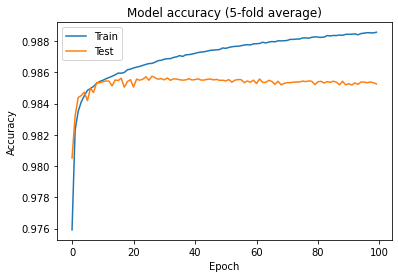

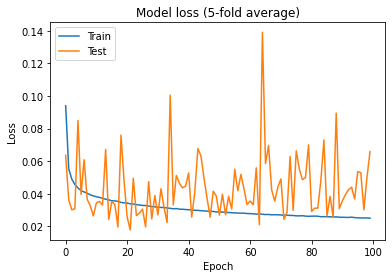

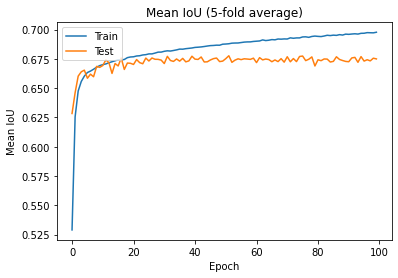

In [8]:
accHis = None
accValHis = None
lossHis = None
lossValHis = None
mIoUHis = None
mIoUValHis = None
for i in range(len(historys)):
    if i == 0:
        accHis = np.array(historys[i].history['accuracy'])
        accValHis = np.array(historys[i].history['val_accuracy'])
        lossHis = np.array(historys[i].history['loss'])
        lossValHis = np.array(historys[i].history['val_loss'])
        mIoUHis = np.array(historys[i].history['new_mean_iou'])
        mIoUValHis = np.array(historys[i].history['val_new_mean_iou'])
    else:
        accHis += np.array(historys[i].history['accuracy'])
        accValHis += np.array(historys[i].history['val_accuracy'])
        lossHis += np.array(historys[i].history['loss'])
        lossValHis += np.array(historys[i].history['val_loss'])
        mIoUHis += np.array(historys[i].history['new_mean_iou'])
        mIoUValHis += np.array(historys[i].history['val_new_mean_iou'])
        

accHis /= len(historys)
accValHis /= len(historys)
lossHis /= len(historys)
lossValHis /= len(historys)
mIoUHis /= len(historys)
mIoUValHis /= len(historys)


import matplotlib.pyplot as plt
plt.plot(accHis)
plt.plot(accValHis)
plt.title('Model accuracy (5-fold average)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.savefig('./UNET_BCE_TRAIN2.png')
plt.show()

# 학습 손실 값과 검증 손실 값을 플롯팅 합니다.
plt.plot(lossHis)
plt.plot(lossValHis)
plt.title('Model loss (5-fold average)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.savefig('./UNET_BCE_LOSS2.png')
plt.show()

# 학습 손실 값과 검증 손실 값을 플롯팅 합니다.
plt.plot(mIoUHis)
plt.plot(mIoUValHis)
plt.title('Mean IoU (5-fold average)')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.savefig('./UNET_BCE_MEANIOU2.png')
plt.show()

In [10]:
with open('./UNET_HISTORY_0.bin','rb') as pi:
    unethis = pickle.load(pi)
unethis

{'loss': [0.06577767489069013,
  0.054884602593981605,
  0.04985028092522146,
  0.046033502411288216,
  0.044122151656203236,
  0.04296082489807582,
  0.0407599988542649,
  0.04088331794856582,
  0.03902856232332642,
  0.038752446184341614,
  0.03746161037588456,
  0.03686336440917801,
  0.03686702477389889,
  0.035559146353149385,
  0.03519497411520842,
  0.034454452468925215,
  0.03424271392588811,
  0.03327057403596373,
  0.0331248602302106,
  0.032058414432434956,
  0.032175758071531245,
  0.031185420341632422,
  0.030956393120721976,
  0.03040835064313503,
  0.029781782158352674,
  0.029677046769899063,
  0.0294689270335504,
  0.028589804877294362,
  0.028204566929147655,
  0.028201038482716663,
  0.027550930148693007,
  0.027155269494746153,
  0.026967732189141808,
  0.026222002304559948,
  0.02596289241794539,
  0.025662098841331617,
  0.025374614517272263,
  0.025508710132894446,
  0.024616454264184868,
  0.024305471365167024,
  0.02428508143946333,
  0.023782244815320146,
  0.

In [13]:
unetHis = []
unetppHis = []
vggHis = []
for i in range(5):
    uname = './UNET_HISTORY_%d.bin'%(i)
    vggname = './VGGFCN_HISTORY_%d.bin'%(i)
    uppname = './UNETPP_HISTORY_%d.bin'%(i)
    with open(uname,'rb') as pi:
        curUnetHis = pickle.load(pi)
    with open(vggname,'rb') as pi:
        curVggHis = pickle.load(pi)
    with open(uppname,'rb') as pi:
        curUppHis = pickle.load(pi)
        
    unetHis.append(curUnetHis)
    vggHis.append(curVggHis)
    unetppHis.append(curUppHis)
len(unetHis),len(vggHis),len(unetppHis)

(5, 5, 5)

In [26]:
unetHis[0].keys(),vggHis[0].keys(),unetppHis[0].keys()

(dict_keys(['loss', 'acc', 'binary_crossentropy', 'iou_coef', 'dice_coef', 'tf_mean_iou', 'new_mean_iou', 'val_loss', 'val_acc', 'val_binary_crossentropy', 'val_iou_coef', 'val_dice_coef', 'val_tf_mean_iou', 'val_new_mean_iou']),
 dict_keys(['loss', 'acc', 'binary_crossentropy', 'iou_coef', 'dice_coef', 'tf_mean_iou', 'new_mean_iou', 'val_loss', 'val_acc', 'val_binary_crossentropy', 'val_iou_coef', 'val_dice_coef', 'val_tf_mean_iou', 'val_new_mean_iou']),
 dict_keys(['val_loss', 'val_accuracy', 'val_binary_crossentropy', 'val_iou_coef', 'val_dice_coef', 'val_tf_mean_iou', 'val_new_mean_iou', 'loss', 'accuracy', 'binary_crossentropy', 'iou_coef', 'dice_coef', 'tf_mean_iou', 'new_mean_iou']))

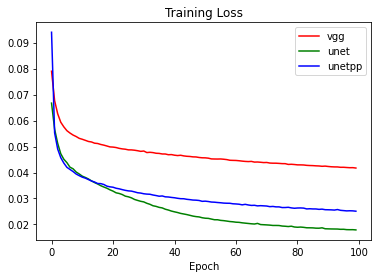

In [45]:
def calculatePlot(historys,what):
    dest = None
    for i in range(len(historys)):
        if i == 0:
            dest = np.array(historys[i][what])
        else:
            dest += np.array(historys[i][what])
    return dest/len(historys)

def draw(vgg,unet,unetpp,label,loc='best'):
    plt.plot(vgg,'r')
    plt.plot(unet,'g')
    plt.plot(unetpp,'b')
    plt.title(label)
    plt.xlabel('Epoch')
    plt.legend(['VGGFCN', 'ResUNet','EfficientUNet'], loc=loc)
    
def drawValid(vgg,unet,unetpp,vggv,unetv,unetppv,label,loc='best'):
    plt.plot(vgg,'r')
    plt.plot(unet,'g')
    plt.plot(unetpp,'b')
    plt.plot(vggv,'r--')
    plt.plot(unetv,'g--')
    plt.plot(unetppv,'b--')
    plt.title(label)
    plt.xlabel('Epoch')
    plt.legend(['VGGFCN training', 'ResUNet training','EfficientUNet training'
             ,'VGGFCN validation', 'ResUNet validation','EfficientUNet validation'  ], loc=loc)
    
vggLoss = calculatePlot(vggHis,'loss')
unetLoss = calculatePlot(unetHis,'loss')
unetppLoss = calculatePlot(unetppHis,'loss')

import matplotlib.pyplot as plt
plt.plot(vggLoss,'r')
plt.plot(unetLoss,'g')
plt.plot(unetppLoss,'b')
plt.title('Training Loss')
#plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.legend(['vgg', 'unet','unetpp'], loc='best')
#plt.savefig('./UNET_BCE_TRAIN2.png')
plt.show()


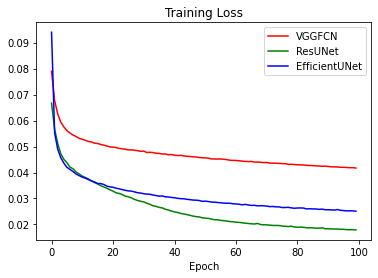

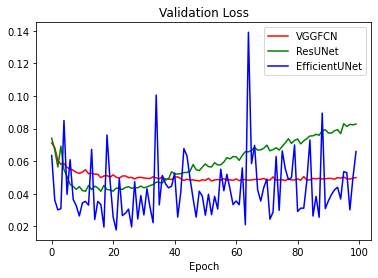

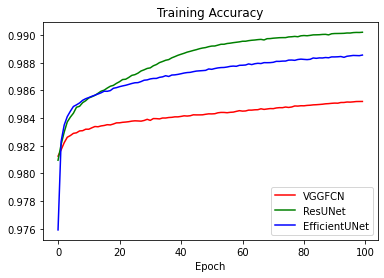

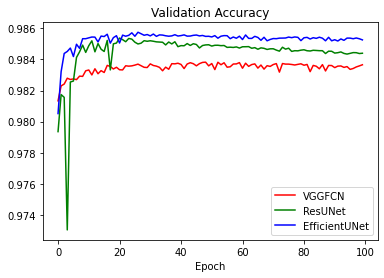

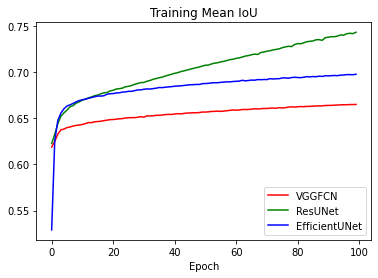

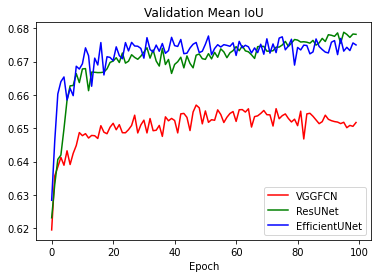

In [37]:
vgg = calculatePlot(vggHis,'loss')
unet = calculatePlot(unetHis,'loss')
unetpp = calculatePlot(unetppHis,'loss')
draw(vgg,unet,unetpp,'Training Loss')
plt.show()

vgg = calculatePlot(vggHis,'val_loss')
unet = calculatePlot(unetHis,'val_loss')
unetpp = calculatePlot(unetppHis,'val_loss')
draw(vgg,unet,unetpp,'Validation Loss')
plt.show()

vgg = calculatePlot(vggHis,'acc')
unet = calculatePlot(unetHis,'acc')
unetpp = calculatePlot(unetppHis,'accuracy')
draw(vgg,unet,unetpp,'Training Accuracy',loc='lower right')
plt.show()

vgg = calculatePlot(vggHis,'val_acc')
unet = calculatePlot(unetHis,'val_acc')
unetpp = calculatePlot(unetppHis,'val_accuracy')
draw(vgg,unet,unetpp,'Validation Accuracy',loc='lower right')
plt.show()

vgg = calculatePlot(vggHis,'new_mean_iou')
unet = calculatePlot(unetHis,'new_mean_iou')
unetpp = calculatePlot(unetppHis,'new_mean_iou')
draw(vgg,unet,unetpp,'Training Mean IoU',loc='lower right')
plt.show()

vgg = calculatePlot(vggHis,'val_new_mean_iou')
unet = calculatePlot(unetHis,'val_new_mean_iou')
unetpp = calculatePlot(unetppHis,'val_new_mean_iou')
draw(vgg,unet,unetpp,'Validation Mean IoU',loc='lower right')
plt.show()

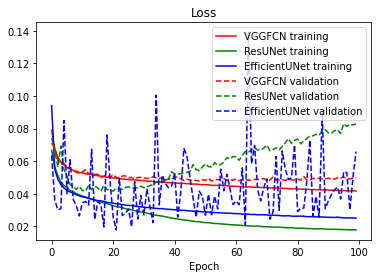

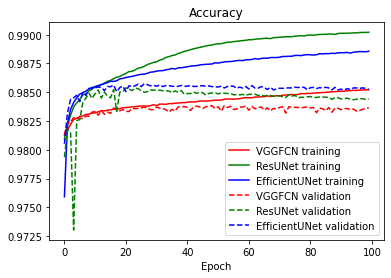

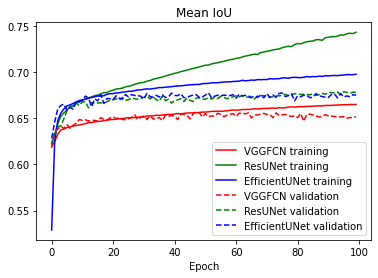

In [46]:
vgg = calculatePlot(vggHis,'loss')
unet = calculatePlot(unetHis,'loss')
unetpp = calculatePlot(unetppHis,'loss')
vggv = calculatePlot(vggHis,'val_loss')
unetv = calculatePlot(unetHis,'val_loss')
unetppv = calculatePlot(unetppHis,'val_loss')

drawValid(vgg,unet,unetpp,vggv,unetv,unetppv,'Loss')
plt.show()

vgg = calculatePlot(vggHis,'acc')
unet = calculatePlot(unetHis,'acc')
unetpp = calculatePlot(unetppHis,'accuracy')
vggv = calculatePlot(vggHis,'val_acc')
unetv = calculatePlot(unetHis,'val_acc')
unetppv = calculatePlot(unetppHis,'val_accuracy')
drawValid(vgg,unet,unetpp,vggv,unetv,unetppv,'Accuracy',loc='lower right')
plt.show()

vgg = calculatePlot(vggHis,'new_mean_iou')
unet = calculatePlot(unetHis,'new_mean_iou')
unetpp = calculatePlot(unetppHis,'new_mean_iou')
vggv = calculatePlot(vggHis,'val_new_mean_iou')
unetv = calculatePlot(unetHis,'val_new_mean_iou')
unetppv = calculatePlot(unetppHis,'val_new_mean_iou')
drawValid(vgg,unet,unetpp,vggv,unetv,unetppv,'Mean IoU',loc='lower right')
plt.show()

In [39]:
with open('./VGGFCN_EVAL.bin','rb') as pi:
    vggEvals = pickle.load(pi)
with open('./UNET_EVAL.bin','rb') as pi:
    unetEvals = pickle.load(pi)
with open('./UNETPP_EVAL_.bin','rb') as pi:
    uppEvals = pickle.load(pi)
len(vggEvals),len(unetEvals),len(uppEvals)

(5, 5, 5)

In [41]:
print('vggfcn')
for ev in vggEvals:
    print(ev[0],ev[1],ev[-1])
print('unet')
for ev in unetEvals:
    print(ev[0],ev[1],ev[-1])
print('unet++')
for ev in uppEvals:
    print(ev[0],ev[1],ev[-1])

vggfcn
0.051580568829264775 0.98340744 0.6546681
0.05036610309392787 0.9836163 0.6502425
0.047474642642415486 0.98411256 0.651417
0.04968488659938452 0.983861 0.6471514
0.050478913671588625 0.9832885 0.6482062
unet
0.0907999854302848 0.9841971 0.67480767
0.0757731805210347 0.98440415 0.6799163
0.08401013494524584 0.9846158 0.6754877
0.08016744034169031 0.9847855 0.6754447
0.07879249260865716 0.9839469 0.67771125
unet++
0.025172822177410126 0.9853494763374329 0.6800488829612732
0.06685163080692291 0.9853338003158569 0.6746584177017212
0.033991530537605286 0.9856236577033997 0.6687915921211243
0.021301088854670525 0.985416829586029 0.6777217388153076
0.02571970410645008 0.9849311113357544 0.6672221422195435


In [15]:


accHis = None
accValHis = None
lossHis = None
lossValHis = None
mIoUHis = None
mIoUValHis = None
for i in range(len(historys)):
    if i == 0:
        accHis = np.array(historys[i].history['accuracy'])
        accValHis = np.array(historys[i].history['val_accuracy'])
        lossHis = np.array(historys[i].history['loss'])
        lossValHis = np.array(historys[i].history['val_loss'])
        mIoUHis = np.array(historys[i].history['new_mean_iou'])
        mIoUValHis = np.array(historys[i].history['val_new_mean_iou'])
    else:
        accHis += np.array(historys[i].history['accuracy'])
        accValHis += np.array(historys[i].history['val_accuracy'])
        lossHis += np.array(historys[i].history['loss'])
        lossValHis += np.array(historys[i].history['val_loss'])
        mIoUHis += np.array(historys[i].history['new_mean_iou'])
        mIoUValHis += np.array(historys[i].history['val_new_mean_iou'])
        

accHis /= len(historys)
accValHis /= len(historys)
lossHis /= len(historys)
lossValHis /= len(historys)
mIoUHis /= len(historys)
mIoUValHis /= len(historys)

dict

In [ ]:
plt.plot(accHis)
plt.plot(accValHis)
plt.title('Model accuracy (5-fold average)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.savefig('./UNET_BCE_TRAIN2.png')
plt.show()

In [15]:
import pickle
for i in range(len(historys)):
    name = './UNETPP_HISTORY_%d.bin'%(i)
    with open(name, 'wb') as file_pi:
        pickle.dump(historys[i].history, file_pi)
    
with open('./UNETPP_EVAL_.bin', 'wb') as file_pi:
    pickle.dump(evaluations, file_pi)    

In [17]:
# 5-fold 평균 결과 출력 

loss = 0
acc = 0
meaniou = 0
each_epoch = []
for i in range(len(evaluations)):
    loss += evaluations[i][0]
    acc += evaluations[i][1]
    meaniou += evaluations[i][6]
    each_epoch.append(len(historys[i].history['accuracy']))
loss /= len(evaluations)
acc /= len(evaluations)
meaniou /= len(evaluations)
print('[TEST AVERAGE] \nloss : %.8lf, acc : %.8lf, mean iou : %.8lf'%(loss,acc,meaniou))
print('total training time : %lf sec'%(sum(times)))
print('each training time :',times)
print('each epoch :',each_epoch)

[TEST AVERAGE] 
loss : 0.03162457, acc : 0.98479511, mean iou : 0.66064996
total training time : 60728.147726 sec
each training time : [7266.577644109726, 11912.493390321732, 7767.49001121521, 10522.483246088028, 23259.103434324265]
each epoch : [23, 37, 23, 31, 67]
